## Calling the Data Reader Class

In [58]:
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

import Random
Random.seed!(42)
d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=true, batch_size=batch_size, dtype=atype)
print("WIDERFACE data is read!")

WIDERFACE data is read!

## Drawing a Ground Truth Image

In [83]:
include("./BBTNet/utils/ImageReader.jl")

train_reader = Image_Reader(true) # true for augmentation, false for only square resize

file_name = "22--Picnic/22_Picnic_Picnic_22_231.jpg"
img, bboxes = read_img(wf_path * "train/images/" * file_name, 640, r=train_reader, boxes=d.bboxes[file_name])
print("Image file is read: ", file_name, '\n')

Image file is read: 22--Picnic/22_Picnic_Picnic_22_231.jpg


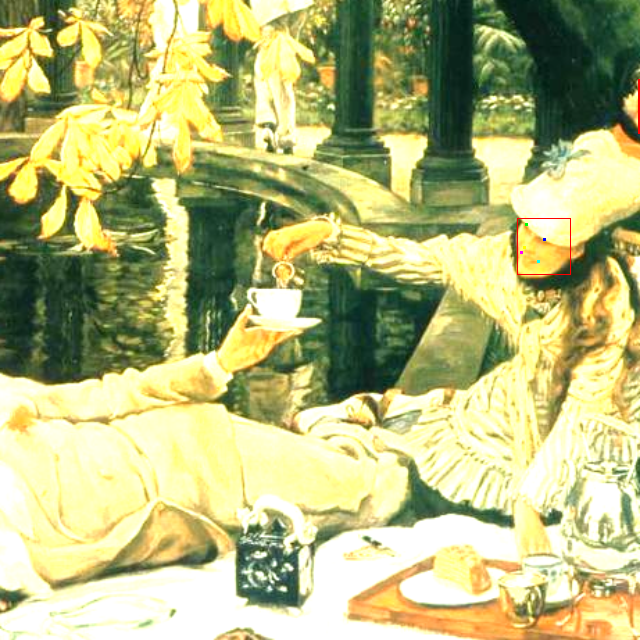

In [84]:
include("./BBTNet/utils/draw.jl")

img = convert(Array{Float32}, img .+ avg_img)
img ./= 255

draw_boxes_and_landmarks(img, bboxes)

## Drawing Image From Manual Data

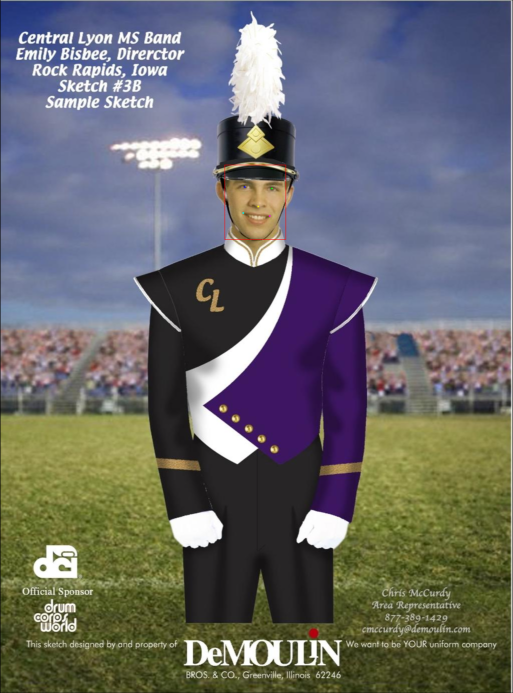

In [85]:
using Images

include("./BBTNet/utils/draw.jl")

d = reshape([449 330 571 479 488.906 373.643 542.089 376.442 515.031 412.83 485.174 425.893 538.357 431.491], (14, 1))
path = wf_path * "train/images/0--Parade/0_Parade_marchingband_1_849.jpg"

img = channelview(load(path))
draw_boxes_and_landmarks(img, d)

## Loading & Saving a Model

In [87]:
model = load_model(save_dir * "PyTorch_R50_mode2_laterals3.jld2")
print("Model is loaded from a file!\n")

Model is loaded from a file!


In [89]:
file_name = "dummy_path.jld2"
save_model(model, save_dir * file_name)
print("Model is saved to:", save_dir * file_name, "\n")

Model is saved to:./weights/dummy_path.jld2


## Training the Model

In [100]:
include("BBTNet/models/retinaface.jl")
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

5-element Array{Dict{String,Any},1}:
 Dict("anchors" => [16.0, 20.16, 25.4],"stride" => 4)
 Dict("anchors" => [32.0, 40.32, 50.8],"stride" => 8)
 Dict("anchors" => [64.0, 80.63, 101.59],"stride" => 16)
 Dict("anchors" => [128.0, 161.26, 203.19],"stride" => 32)
 Dict("anchors" => [256.0, 322.54, 406.37],"stride" => 64)

In [111]:
include("BBTNet/models/retinaface.jl")
include("BBTNet/datasets/WIDERFACE.jl")
include("configs.jl")

batch_size = 4
# d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=false, shuffle=false, batch_size=6, dtype=KnetArray{Float64})
d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=false, shuffle=false, batch_size=batch_size, dtype=atype)
print("Data is loaded...")

12880-element Array{String,1}:
 "0--Parade/0_Parade_marchingband_1_849.jpg"
 "0--Parade/0_Parade_Parade_0_904.jpg"
 "0--Parade/0_Parade_marchingband_1_799.jpg"
 "0--Parade/0_Parade_marchingband_1_117.jpg"
 "0--Parade/0_Parade_marchingband_1_778.jpg"
 "0--Parade/0_Parade_Parade_0_343.jpg"
 "0--Parade/0_Parade_marchingband_1_205.jpg"
 "0--Parade/0_Parade_Parade_0_106.jpg"
 "0--Parade/0_Parade_Parade_0_476.jpg"
 "0--Parade/0_Parade_marchingband_1_12.jpg"
 "0--Parade/0_Parade_marchingband_1_273.jpg"
 "0--Parade/0_Parade_marchingband_1_928.jpg"
 "0--Parade/0_Parade_Parade_0_337.jpg"
 ⋮
 "9--Press_Conference/9_Press_Conference_Press_Conference_9_623.jpg"
 "9--Press_Conference/9_Press_Conference_Press_Conference_9_861.jpg"
 "9--Press_Conference/9_Press_Conference_Press_Conference_9_358.jpg"
 "9--Press_Conference/9_Press_Conference_Press_Conference_9_940.jpg"
 "9--Press_Conference/9_Press_Conference_Press_Conference_9_893.jpg"
 "9--Press_Conference/9_Press_Conference_Press_Conference_9_925.jpg

In [112]:
# model = RetinaFace(dtype=KnetArray{Float64})
model = RetinaFace(dtype=atype)
print("Model is loaded...")

Model is loaded...

In [113]:
train_model(model, d)

E: 1 --> Total Loss: 90.563 | Cls Loss: 77.952 | Box Loss: 1.4030 | Point Loss: 4.5810 | Decay: 5.2230
Total Loss: 422.115 | Cls Loss: 411.729 | Box Loss: 0.9750 | Point Loss: 3.2130 | Decay: 5.2230
Total Loss: 263.562 | Cls Loss: 253.179 | Box Loss: 1.1110 | Point Loss: 2.9370 | Decay: 5.2240
Total Loss: 214.912 | Cls Loss: 204.685 | Box Loss: 1.1220 | Point Loss: 2.7580 | Decay: 5.2240
Total Loss: 205.384 | Cls Loss: 195.118 | Box Loss: 1.1180 | Point Loss: 2.8050 | Decay: 5.2250
E: 1 --> Total Loss: 104.617 | Cls Loss: 94.297 | Box Loss: 1.1680 | Point Loss: 2.7570 | Decay: 5.2270
Total Loss: 431.281 | Cls Loss: 421.954 | Box Loss: 0.7480 | Point Loss: 2.6020 | Decay: 5.2280
Total Loss: 140.315 | Cls Loss: 131.847 | Box Loss: 0.6830 | Point Loss: 1.8720 | Decay: 5.2300


LoadError: InterruptException:

## Testing the Model

#### Testing a Batch

In [2]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

Random.seed!(42)

val_data = WIDER_Data(wf_path * "val/", wf_labels_path * "val/", train=false, batch_size=batch_size, dtype=atype)
(imgs, boxes), state = iterate(val_data)

# model = RetinaFace(dtype=atype)
model = load_model(save_dir * "PyTorch_R50_mode2_laterals3.jld2")
c, b, l = model(imgs, mode=mode, train=false)

for b in 1:batch_size
    print("For Batch Image: ", b, " found ", size(c[b],1), " proposals!\n")
end

For Batch Image: 1 found 1 proposals!
For Batch Image: 2 found 1 proposals!
For Batch Image: 3 found 1 proposals!
For Batch Image: 4 found 1 proposals!
For Batch Image: 5 found 1 proposals!
For Batch Image: 6 found 1 proposals!
For Batch Image: 7 found 1 proposals!
For Batch Image: 8 found 1 proposals!
For Batch Image: 9 found 1 proposals!
For Batch Image: 10 found 1 proposals!


#### Testing an Individual Image

[INFO] Returning results above confidence level: 0.6.


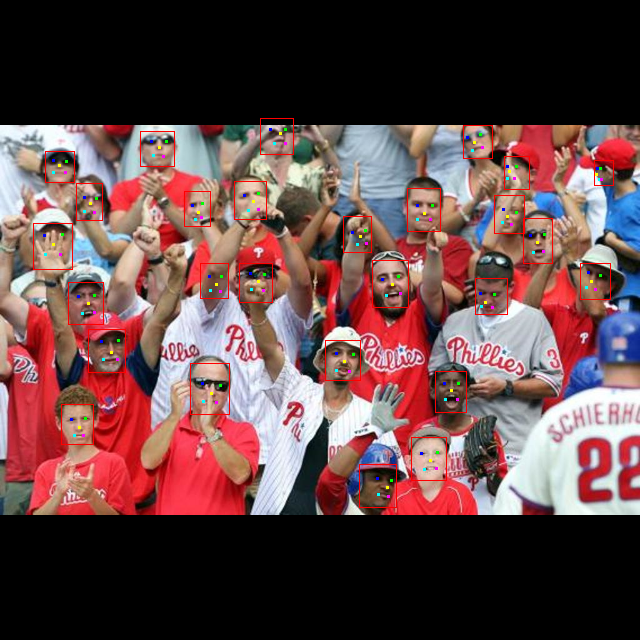

In [6]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("BBTNet/models/pth_load_retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")


img_path = "data/test.jpg"

img = read_img(img_path, img_size)
reversed_img = reverse(img, dims=1)
imgs = convert(atype, permutedims(reshape(reversed_img, (3, img_size, img_size, 1)), (3,2,1,4)))

# model = RetinaFace(dtype=atype)
# model = load_pth_model(model, save_dir * "Resnet50.jld"; dtype=atype)
model = load_model(save_dir * "PyTorch_R50_mode2_laterals3.jld2")
c, b, l = predict_model(model, imgs; mode=mode) 

combined_pts = cat(b[1], l[1], dims=1)
img = convert(Array{Float32}, img .+ avg_img)
img ./= 255

draw_boxes_and_landmarks(img, combined_pts)

In [127]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("BBTNet/models/pth_load_retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

5-element Array{Dict{String,Any},1}:
 Dict("anchors" => [16.0, 20.16, 25.4],"stride" => 4)
 Dict("anchors" => [32.0, 40.32, 50.8],"stride" => 8)
 Dict("anchors" => [64.0, 80.63, 101.59],"stride" => 16)
 Dict("anchors" => [128.0, 161.26, 203.19],"stride" => 32)
 Dict("anchors" => [256.0, 322.54, 406.37],"stride" => 64)

In [16]:
# model = RetinaFace(dtype=atype)
# model = load_pth_model(model, save_dir * "Resnet50.jld"; dtype=atype)
model2 = load_model("weights/overfit_model_80.jld2")
print("Model is loaded!")

Model is loaded!

In [143]:
d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", 
    train=false, batch_size=batch_size, dtype=atype)

print("WIDER Data loaded!")

WIDER Data loaded!

In [11]:
d.files[1:10]

10-element Array{String,1}:
 "0--Parade/0_Parade_marchingband_1_849.jpg"
 "0--Parade/0_Parade_Parade_0_904.jpg"
 "0--Parade/0_Parade_marchingband_1_799.jpg"
 "0--Parade/0_Parade_marchingband_1_117.jpg"
 "0--Parade/0_Parade_marchingband_1_778.jpg"
 "0--Parade/0_Parade_Parade_0_343.jpg"
 "0--Parade/0_Parade_marchingband_1_205.jpg"
 "0--Parade/0_Parade_Parade_0_106.jpg"
 "0--Parade/0_Parade_Parade_0_476.jpg"
 "0--Parade/0_Parade_marchingband_1_12.jpg"

In [21]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("BBTNet/models/pth_load_retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("configs.jl")

img_path = "data/test.jpg"

name = d.files[1]
img2_path = wf_path * "train/images/" * name

img, boxes = read_img(img2_path, img_size, r=d.reader, boxes=d.bboxes[name])
reversed_img = reverse(img, dims=1)
imgs = convert(atype, permutedims(reshape(reversed_img, (3, img_size, img_size, 1)), (3,2,1,4)))
print("Image is read!\n")

Image is read!


In [22]:
# conf_level = 0.9
c, b, l = predict_model(model, imgs; y=boxes, mode=2) 
print("Number of faces predicted: ", size(b[1]), "\n")

Classvals --> Float32[0.813761]
Boxes: --> [288.07784420251846; 157.133131980896; 334.70435482263565; 202.40696239471436]
Landmarks: --> [334.5178737640381; 153.32406616210938; 324.63568687438965; 178.08636569976807; 307.3972249031067; 161.43339347839355; 273.76186752319336; 176.35221099853516; 319.00004959106445; 204.1038703918457]
[INFO] Returning results above confidence level: 0.5.
Number of faces predicted: (4, 1)


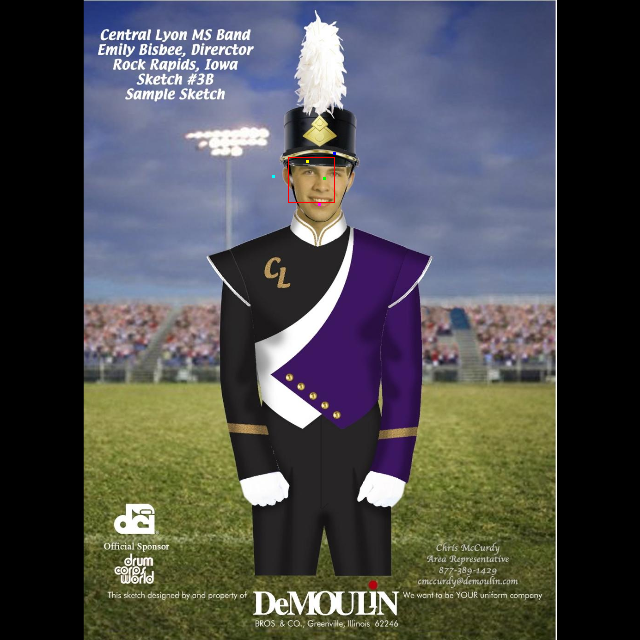

In [23]:
include("./BBTNet/utils/draw.jl")

b[1] = reshape([288.07784420251846; 157.133131980896; 334.70435482263565; 202.40696239471436], (4, 1))
l[1] = reshape([334.5178737640381; 153.32406616210938; 324.63568687438965; 178.08636569976807; 307.3972249031067; 161.43339347839355; 273.76186752319336; 176.35221099853516; 319.00004959106445; 204.1038703918457], (10, 1))

combined_pts = cat(b[1], l[1], dims=1)
scaled_img = convert(Array{Float32}, img .+ avg_img) ./ 255

draw_boxes_and_landmarks(scaled_img, combined_pts)

In [68]:
size(l[1])

(10, 1)

In [36]:
include("./BBTNet/core/metrics.jl")

min_dist = 100000
max_area = -1
min_idx = -1
max_idx = -1

for el in 1:size(b[1], 2)
    
    mdist = (b[1][3,el] - b[1][1,el])*(b[1][4,el] - b[1][2,el])
    if mdist < min_dist
        min_dist = mdist
        min_idx = el
    end
    if mdist > max_area
        max_area = mdist
        max_idx = el
    end
        
    # ious = iou(b[1][:,el:el], b[1][:,el+1:end])
    # print(maximum(ious), " & ")
end

print(min_dist, " & ", max_area, " & ", min_idx, " & ", max_idx)

628.4154971286063 & 2748.3061459335886 & 3539 & 252

In [43]:
size(b[1])

(4, 14642)

In [30]:
min_dist

628.4154971286063

In [28]:
min_idx

3374

In [55]:
include("./BBTNet/utils/box_processes.jl")

init_mm = reshape([231.5 92.6 347.9 141.8], (4, 1, 1))
anchors = _get_priorboxes()[:, 734:734]

4×1 Array{Float64,2}:
 338.0
   6.0
  20.16
  20.16

In [54]:
_to_center_length_form(init_mm)

4×1×1 Array{Float64,3}:
[:, :, 1] =
 289.7
 117.2
 116.39999999999998
  49.20000000000002

In [57]:
function encode_vals(gt, selected_priors)
    gt[1:4,:] = _to_center_length_form(gt[1:4,:])
    gt[3:4,:] = log.(gt[3:4,:] ./ selected_priors[3:4,:])
    gt[1:2,:] = (gt[1:2,:] .- selected_priors[1:2,:]) ./ selected_priors[3:4,:]
    return gt
end

converted = encode_vals(deepcopy(init_mm), anchors)

4×1×1 Array{Float64,3}:
[:, :, 1] =
 -2.395833333333334
  5.515873015873016
  1.7533320920941695
  0.8921931802950949

In [59]:
_to_min_max_form(_decode_bboxes(converted, anchors))

4×1×1 Array{Float64,3}:
[:, :, 1] =
 231.5
  92.6
 347.9
 141.8

In [60]:
init_mm

4×1×1 Array{Float64,3}:
[:, :, 1] =
 231.5
  92.6
 347.9
 141.8

In [10]:
(imgs, boxes), state = iterate(d)

((K32(640,640,3,4)[-104.0⋯], Any[[291.1191335740072; 152.49097472924188; … ; 199.38934296028881; 0.4620938628158845], [252.51396648044692; 43.798882681564244; … ; 153.22413407821227; 0.44692737430167595], [48.75 48.75 … 1.875 12.5; 218.125 228.75 … 225.0 214.375; … ; 79.375 236.65187500000002 … 233.125 223.125; -1.0 0.625 … 0.625 0.625], [43.125 141.875 … 373.75 462.5; 331.25 345.625 … 260.625 299.375; … ; 342.58375 366.875 … 274.375 106.25; 0.625 0.625 … 0.625 -1.0]]), [5, 6, 7, 8, 9, 10, 11, 12])

In [88]:
size(boxes[1])

(15, 1)

In [63]:
using AutoGrad, Knet

@gcheck model(imgs, boxes)

Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | Point Loss: 0.0000 | Decay: 0.0000
Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | Point Loss: 0.0000 | Decay: 0.0000
Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | Point Loss: 0.0000 | Decay: 0.0000
Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | Point Loss: 0.0000 | Decay: 0.0000
Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | Point Loss: 0.0000 | Decay: 0.0000
Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | Point Loss: 0.0000 | Decay: 0.0000
Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | Point Loss: 0.0000 | Decay: 0.0000
Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | Point Loss: 0.0000 | Decay: 0.0000
Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | Point Loss: 0.0000 | Decay: 0.0000
Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | Point Loss: 0.0000 | Decay: 0.0000
Total Loss: 0.7260 | Cls Loss: 0.7260 | Box Loss: 0.0000 | P

LoadError: InterruptException:

In [79]:
ceil.(randn(14, 2))

14×2 Array{Float64,2}:
 -0.0  -1.0
 -0.0  -0.0
 -1.0   2.0
 -0.0   1.0
  1.0   2.0
 -2.0   1.0
 -0.0   1.0
  1.0   1.0
  1.0  -0.0
  1.0  -1.0
  1.0   1.0
 -2.0  -0.0
  1.0  -0.0
 -0.0  -0.0

In [63]:
include("BBTNet/datasets/WIDERFACE.jl")
include("BBTNet/models/retinaface.jl")
include("BBTNet/models/pth_load_retinaface.jl")
include("./BBTNet/utils/draw.jl")
include("./BBTNet/utils/box_processes.jl")
include("./BBTNet/core/metrics.jl")
include("configs.jl")

5-element Array{Dict{String,Any},1}:
 Dict("anchors" => [16.0, 20.16, 25.4],"stride" => 4)
 Dict("anchors" => [32.0, 40.32, 50.8],"stride" => 8)
 Dict("anchors" => [64.0, 80.63, 101.59],"stride" => 16)
 Dict("anchors" => [128.0, 161.26, 203.19],"stride" => 32)
 Dict("anchors" => [256.0, 322.54, 406.37],"stride" => 64)

In [64]:
d = WIDER_Data(wf_path * "train/", wf_labels_path * "train/", train=false, shuffle=true, batch_size=1, dtype=atype)
print("WIDER Data loaded!")

WIDER Data loaded!

In [65]:
d.files[1]

"0--Parade/0_Parade_marchingband_1_849.jpg"

In [66]:
(imgs, boxes), state = iterate(d)
print("First batch is retrieved")

First batch is retrieved

In [67]:
size(boxes[1])

(15, 4)

In [69]:
model = RetinaFace(dtype=atype)
print("The model is declared!")

The model is declared!

In [70]:
cls_vals, bbox_vals, lm_vals = model(imgs, mode=2, train=true)
T, P, N = size(cls_vals); batch_cls = convert(Array{Int64}, zeros(P, N)); batch_gt = cat(value(bbox_vals), value(lm_vals), dims=1);
l_cls =Array(value(cls_vals))[1,:,1]; gt = boxes[1]; prior = _get_priorboxes();
print("Forward pass completed!")

Forward pass completed!

In [71]:
iou_vals = iou(gt[1:4,:], _to_min_max_form(prior))
# gets max values and indices for each gt
max_gt_vals, max_gt_idx = findmax(iou_vals; dims=1)
# gets max values and indices for each prior
max_prior_vals, max_prior_idx = findmax(iou_vals; dims=2) 
print("Selecting indices...")

Selecting indices...

In [72]:
max_gt_vals

1×4 Array{Float64,2}:
 0.677626  0.734251  0.696872  0.746389

In [74]:
print(max_gt_idx)

CartesianIndex{2}[CartesianIndex(97490, 1) CartesianIndex(97271, 2) CartesianIndex(98076, 3) CartesianIndex(98585, 4)]

In [79]:
maximum(iou_vals[:,4]), iou_vals[98585, 4]

(0.7463887599303769, 0.7463887599303769)

In [83]:
neg_indices = getindex.(findall(max_prior_vals .<= 0.3), [1 2])[:,1]
neg_indices = neg_indices[sortperm(l_cls[neg_indices])]

101936-element Array{Int64,1}:
 56891
 33457
 49066
 20372
 49594
 98672
 49069
 33476
 49546
 49072
 18458
 33956
 49510
     ⋮
 57843
 91814
 87893
 54954
 39954
 20367
 56409
 55426
 43512
 56412
 43032
 54951

In [86]:
l_cls[neg_indices[1:10]]

10-element Array{Float32,1}:
 0.00047626003
 0.0009929155
 0.0014269147
 0.0015187517
 0.0016231022
 0.00196471
 0.002312084
 0.0030606817
 0.0030644597
 0.0031057203

In [80]:
pos_selected = findall(max_gt_vals .>= 0.5)
pos_gt_indices = getindex.(pos_selected, [1 2])[:, 2]
pos_prior_indices = getindex.(max_gt_idx[pos_selected], [1 2])[:, 1] 
num_poses = length(pos_gt_indices)

4

In [82]:
pos_prior_indices

4-element Array{Int64,1}:
 97490
 97271
 98076
 98585

In [87]:
neg_cnt = 3 * num_poses
neg_cnt = neg_cnt < 1 ? 1 : neg_cnt 
neg_indices = neg_indices[1:neg_cnt]

12-element Array{Int64,1}:
 56891
 33457
 49066
 20372
 49594
 98672
 49069
 33476
 49546
 49072
 18458
 33956

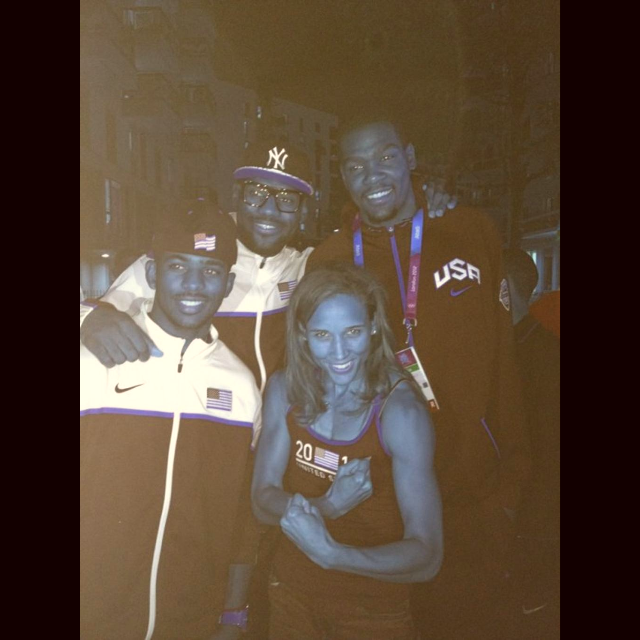

In [68]:
colorview(RGB, (Array(permutedims(imgs[:,:,:,1], (3, 2, 1)))  .+= avg_img) ./255)

In [95]:
arr1 = randn(2, 10, 3)
loss1 = softmax(arr1, dims=1)

2×10×3 Array{Float64,3}:
[:, :, 1] =
 0.672445  0.47311  0.457574  0.573945  …  0.145608  0.153115  0.484879
 0.327555  0.52689  0.542426  0.426055     0.854392  0.846885  0.515121

[:, :, 2] =
 0.391079  0.650774  0.510311  0.0807776  …  0.685637  0.756822  0.186113
 0.608921  0.349226  0.489689  0.919222      0.314363  0.243178  0.813887

[:, :, 3] =
 0.624629  0.103729  0.89944  0.681028  …  0.414609  0.58335  0.404251
 0.375371  0.896271  0.10056  0.318972     0.585391  0.41665  0.595749

In [96]:
for n in 1:3
    for a in 1:10
        print("N: ", n, " & a: ", a, " ---> ", loss1[:,a,n], "\n")
    end
end

N: 1 & a: 1 ---> [0.6724445988755855, 0.3275554011244144]
N: 1 & a: 2 ---> [0.4731096006103401, 0.52689039938966]
N: 1 & a: 3 ---> [0.4575738904908689, 0.5424261095091311]
N: 1 & a: 4 ---> [0.5739445614872896, 0.42605543851271044]
N: 1 & a: 5 ---> [0.9177836554981373, 0.08221634450186267]
N: 1 & a: 6 ---> [0.8369118004105084, 0.16308819958949156]
N: 1 & a: 7 ---> [0.1881939053833969, 0.8118060946166031]
N: 1 & a: 8 ---> [0.14560829640354508, 0.8543917035964549]
N: 1 & a: 9 ---> [0.153115299572688, 0.846884700427312]
N: 1 & a: 10 ---> [0.4848787628974122, 0.5151212371025877]
N: 2 & a: 1 ---> [0.3910791357765039, 0.6089208642234961]
N: 2 & a: 2 ---> [0.6507744490876387, 0.34922555091236135]
N: 2 & a: 3 ---> [0.510311157868133, 0.489688842131867]
N: 2 & a: 4 ---> [0.08077760933295344, 0.9192223906670466]
N: 2 & a: 5 ---> [0.2419814212933137, 0.7580185787066863]
N: 2 & a: 6 ---> [0.8114877850087302, 0.18851221499126983]
N: 2 & a: 7 ---> [0.6920419010127586, 0.30795809898724125]
N: 2 & a: 8

In [104]:
bcls = convert(Array{Int64}, zeros(10, 3))

poslar1 = [7, 9]; poslar2 = [5, 10]; poslar3 = [2, 7];
neglar1 = [8, 3, 2]; neglar2 = [4, 1]; neglar3 = [5, 6, 10];

bcls[poslar1,1] .= 2; bcls[poslar2,2] .= 2; bcls[poslar3,3] .= 2;
bcls[neglar1,1] .= 1; bcls[neglar2,2] .= 1; bcls[neglar3,3] .= 1;

In [105]:
nll(reshape(arr1, (2, 30)), vec(bcls), average=false)

(12.881187063879382, 14)

In [106]:
bcls

10×3 Array{Int64,2}:
 0  1  0
 1  0  2
 1  0  0
 0  1  0
 0  2  1
 0  0  1
 2  0  2
 1  0  0
 2  0  0
 0  2  1

In [114]:
arr_flat = reshape(loss1, (2, 30))
bcls_flat = vec(bcls)

cnt = 0
losses = 0

for p in 1:30
    if bcls_flat[p] == 0
        continue
    else
        losses += -log(arr_flat[bcls_flat[p],p])
    end
end

losses

12.881187063879382

In [ ]:
N: 1 & a: 1 ---> [0.6724445988755855, 0.3275554011244144]
N: 1 & a: 2 ---> [0.4731096006103401, 0.52689039938966]
N: 1 & a: 3 ---> [0.4575738904908689, 0.5424261095091311]
N: 1 & a: 4 ---> [0.5739445614872896, 0.42605543851271044]
N: 1 & a: 5 ---> [0.9177836554981373, 0.08221634450186267]
N: 1 & a: 6 ---> [0.8369118004105084, 0.16308819958949156]
N: 1 & a: 7 ---> [0.1881939053833969, 0.8118060946166031]
N: 1 & a: 8 ---> [0.14560829640354508, 0.8543917035964549]
N: 1 & a: 9 ---> [0.153115299572688, 0.846884700427312]
N: 1 & a: 10 ---> [0.4848787628974122, 0.5151212371025877]
N: 2 & a: 1 ---> [0.3910791357765039, 0.6089208642234961]
N: 2 & a: 2 ---> [0.6507744490876387, 0.34922555091236135]
N: 2 & a: 3 ---> [0.510311157868133, 0.489688842131867]
N: 2 & a: 4 ---> [0.08077760933295344, 0.9192223906670466]
N: 2 & a: 5 ---> [0.2419814212933137, 0.7580185787066863]
N: 2 & a: 6 ---> [0.8114877850087302, 0.18851221499126983]
N: 2 & a: 7 ---> [0.6920419010127586, 0.30795809898724125]
N: 2 & a: 8 ---> [0.6856371081285132, 0.3143628918714869]
N: 2 & a: 9 ---> [0.7568217853574376, 0.24317821464256237]
N: 2 & a: 10 ---> [0.18611337133565756, 0.8138866286643425]
N: 3 & a: 1 ---> [0.624628783441546, 0.37537121655845396]
N: 3 & a: 2 ---> [0.10372932061594488, 0.8962706793840551]
N: 3 & a: 3 ---> [0.89943974492121, 0.10056025507878992]
N: 3 & a: 4 ---> [0.6810283872793615, 0.3189716127206384]
N: 3 & a: 5 ---> [0.2662815689233087, 0.7337184310766913]
N: 3 & a: 6 ---> [0.07566647981132696, 0.9243335201886731]
N: 3 & a: 7 ---> [0.17443394347077695, 0.825566056529223]
N: 3 & a: 8 ---> [0.41460940469493796, 0.5853905953050621]
N: 3 & a: 9 ---> [0.5833495870733454, 0.4166504129266546]
N: 3 & a: 10 ---> [0.4042506856079361, 0.5957493143920639]

In [100]:
reshape(arr1, (2, 30)), vec(bcls)

([1.1321232258496527 -0.16669147183818914 … 0.7883555722114921 -0.31286346059460524; 0.4128607031287002 -0.05902599113773863 … 0.4518164626872556 0.07492131009634674], [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.0  …  0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0])